My primary objective of the project was to develop a deeper understanding of natural language processing techniques and machine learning algorithms. In the code below there is Twitter sentiment analysis model with python using a dataset (from kaggle) with tweets realted to the COVID19 pandemic and the Pfizer vaccines.

In [196]:
import pandas as pd 
import numpy as np
import re 
import seaborn as sns 
import matplotlib.pyplot as plt
from  matplotlib import style 
style.use('ggplot')
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\perez\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\perez\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [197]:
df = pd.read_csv(r"C:\Users\perez\Documents\MachineLearning\sentimentalAnalisis\vaccination_tweets.csv")
df.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False


In [198]:

df.isnull().sum()


id                     0
user_name              0
user_location       2270
user_description     680
user_created           0
user_followers         0
user_friends           0
user_favourites        0
user_verified          0
date                   0
text                   0
hashtags            2582
source                 1
retweets               0
favorites              0
is_retweet             0
dtype: int64

In [199]:
df.columns

Index(['id', 'user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'text', 'hashtags', 'source', 'retweets', 'favorites',
       'is_retweet'],
      dtype='object')

In [200]:
# We will be removing all the other columns since we only want the text column
text_df = df.drop(['id', 'user_name', 'user_location', 'user_description', 'user_created',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
       'date', 'hashtags', 'source', 'retweets', 'favorites',
       'is_retweet'], axis=1) 
text_df.head()

,text
0,Same folks said daikon paste could treat a cyt...
1,While the world has been on the wrong side of ...
2,#coronavirus #SputnikV #AstraZeneca #PfizerBio...
3,"Facts are immutable, Senator, even when you're..."
4,Explain to me again why we need a vaccine @Bor...


In [201]:
text_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11020 entries, 0 to 11019
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    11020 non-null  object
dtypes: object(1)
memory usage: 86.2+ KB


In [202]:
# Data processing is meant to convert the data into a usable format. That is what we are doing in this function.
def data_processing(text):
    # Convert the text to lowercase to ensure consistent processing
    text = text.lower()
    # Remove hyperlinks (URLs) from the text using regular expressions
    text = re.sub(r"https\S+|www\S+https\S+", '', text, flags=re.MULTILINE)
    # Remove mentions and hashtags from the text using regular expressions
    text = re.sub(r'\@\w+|\#', '', text)
    # Remove all non-alphanumeric characters (punctuation, symbols, etc.) from the text
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize the text into individual words using NLTK's word_tokenize function
    text_tokens = word_tokenize(text)
    # Remove stopwords (common words that do not carry much meaning) from the text
    filtered_text = [w for w in text_tokens if not w in stop_words]
    # Join the filtered words back into a single string and return the preprocessed text
    return " ".join(filtered_text)


In [203]:

text_df.text = text_df['text'].apply(data_processing)
text_df = text_df.drop_duplicates('text')


In [204]:
stemmer = PorterStemmer()
def stemming(data):
     # Apply stemming to each word in the input data list
    # Stemming reduces words to their base or root form
    # For example, 'running', 'runs', 'ran' all become 'run
    text = [stemmer.stem(word) for word in data]
    return data

In [205]:
text_df['text'] = text_df['text'].apply(lambda x: stemming(x))
text_df.head()

,text
0,folks said daikon paste could treat cytokine s...
1,world wrong side history year hopefully bigges...
2,coronavirus sputnikv astrazeneca pfizerbiontec...
3,facts immutable senator even youre ethically s...
4,explain need vaccine whereareallthesickpeople ...


In [177]:
text_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 10450 entries, 0 to 11019
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   text       10450 non-null  object 
 1   polarity   10450 non-null  float64
 2   sentiment  10450 non-null  object 
dtypes: float64(1), object(2)
memory usage: 326.6+ KB


In [157]:
# add a polarity column to the dataphrame 
def polarity(text):
    # Use TextBlob to calculate the sentiment polarity of the input text
    # Sentiment polarity ranges from -1 (most negative) to 1 (most positive)
    # Values closer to 0 represent neutral sentiment
    return TextBlob(text).sentiment.polarity
# Apply the polarity function to the 'text' column of the DataFrame
# and create a new column 'polarity' to store the polarity values
text_df['polarity'] = text_df['text'].apply(polarity)
text_df.head(10)

,text,polarity
0,folks said daikon paste could treat cytokine s...,0.000
1,world wrong side history year hopefully bigges...,-0.500
2,coronavirus sputnikv astrazeneca pfizerbiontec...,0.000
3,facts immutable senator even youre ethically s...,0.100
4,explain need vaccine whereareallthesickpeople ...,0.000
5,anyone useful adviceguidance whether covid vac...,0.400
6,bit sad claim fame success vaccination patriot...,-0.100
7,many bright days 2020 best 1 bidenharris winni...,0.675
8,covid vaccine getting covidvaccine covid19 pfi...,0.000
9,covidvaccine states start getting covid19vacci...,0.000


In [160]:
# add a polarity column to the dataphrame 
def sentiment(label):
    if label < 0:
        return "Negative"
    elif label == 0:
        return "Neutral"
    elif label > 0:
        return "Positive"
# Apply the sentiment function to the 'polarity' column of the DataFrame
# and create a new column 'sentiment' to store the sentiment labels
text_df['sentiment'] = text_df['polarity'].apply(sentiment)
text_df.head(10)

,text,polarity,sentiment
0,folks said daikon paste could treat cytokine s...,0.000,Neutral
1,world wrong side history year hopefully bigges...,-0.500,Negative
2,coronavirus sputnikv astrazeneca pfizerbiontec...,0.000,Neutral
3,facts immutable senator even youre ethically s...,0.100,Positive
4,explain need vaccine whereareallthesickpeople ...,0.000,Neutral
5,anyone useful adviceguidance whether covid vac...,0.400,Positive
6,bit sad claim fame success vaccination patriot...,-0.100,Negative
7,many bright days 2020 best 1 bidenharris winni...,0.675,Positive
8,covid vaccine getting covidvaccine covid19 pfi...,0.000,Neutral
9,covidvaccine states start getting covid19vacci...,0.000,Neutral


<Axes: xlabel='sentiment', ylabel='count'>

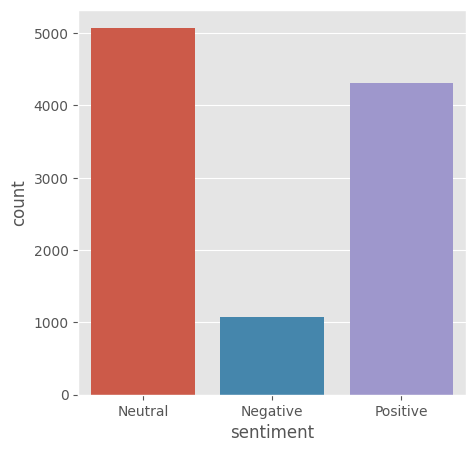

In [161]:
fig = plt.figure(figsize=(5,5))
sns.countplot(x='sentiment', data=text_df)

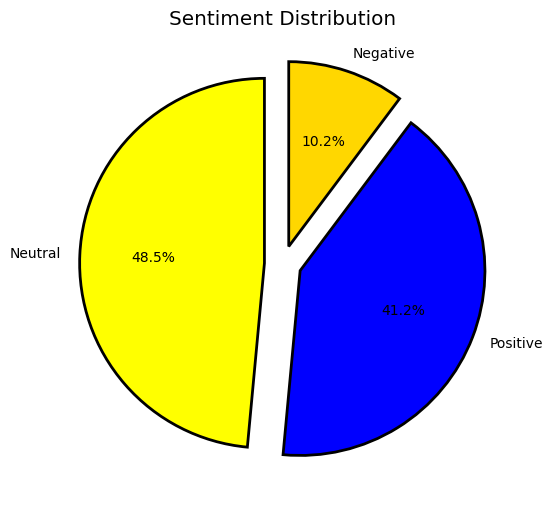

In [162]:
# Creating a pie chart
fig = plt.figure(figsize=(6, 6))
colors = ('yellow', 'blue', 'gold')
wp = {'linewidth': 2, 'edgecolor': 'black'}
tags = text_df['sentiment'].value_counts()
explode = (0.1, 0.1, 0.1)
tags.plot(kind='pie', autopct='%1.1f%%', shadow=False, colors=colors,
          startangle=90, wedgeprops=wp, explode=explode, label='')
plt.title('Sentiment Distribution')

plt.show()




In [163]:
vect = CountVectorizer(ngram_range=(1,2)).fit(text_df['text'])


In [164]:
feature_names = vect.get_feature_names_out()
print("Number of features: {}\n".format(len(feature_names)))
print("First 20 features: {}\n".format(feature_names[:20]))


Number of features: 71637

First 20 features: ['000' '000 doses' '000 initial' '000 people' '000 vaccines' '0000001'
 '0000001 covid19' '0011' '0011 abt' '004' '004 covid' '004 israelis' '01'
 '01 getting' '01 june' '01 november' '01aug2021' '01aug2021 doublevaxxed'
 '02' '02 175']



In [165]:
#Build a model
X = text_df['text']
Y = text_df['sentiment']
X = vect.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


In [166]:
logreg = LogisticRegression()
logreg.fit(X_train,y_train)
logreg_pred = logreg.predict(X_test)
logreg_acc = accuracy_score(logreg_pred, y_test)
print('Test accuracy: {:.2f}%'.format(logreg_acc*100))

Test accuracy: 84.64%


In [167]:
print(confusion_matrix(y_test, logreg_pred))
print(classification_report(y_test, logreg_pred))

[[ 80 115  41]
 [  4 993  12]
 [ 15 134 696]]
              precision    recall  f1-score   support

    Negative       0.81      0.34      0.48       236
     Neutral       0.80      0.98      0.88      1009
    Positive       0.93      0.82      0.87       845

    accuracy                           0.85      2090
   macro avg       0.85      0.72      0.74      2090
weighted avg       0.85      0.85      0.83      2090



In [168]:
# Helps understand the model preformance.
from sklearn.neighbors import KNeighborsClassifier
# Create a KNeighborsClassifier instance
knn = KNeighborsClassifier()
# Train the K-NN classifier using the training dat a
knn.fit(X_train, y_train)
# Print the accuracy of the K-NN classifier on the training set
print('Accuracy of K-NN classifier on training set: {:.2f}'.format(knn.score(X_train, y_train)))
# Print the accuracy of the K-NN classifier on the test set
print('Accuracy of K-NN classifier on test set: {:.2f}'.format(knn.score(X_test, y_test)))


Accuracy of K-NN classifier on training set: 0.58
Accuracy of K-NN classifier on test set: 0.55


In [169]:
from sklearn.svm import SVC
# Create an SVC instance
svm = SVC()
# Train the SVM classifier using the training data
svm.fit(X_train, y_train)
# Print the accuracy of the SVM classifier on the training set
print('Accuracy of SVM classifier on training set: {:.2f}'.format(svm.score(X_train, y_train)))
# Print the accuracy of the SVM classifier on the test set
print('Accuracy of SVM classifier on test set: {:.2f}'.format(svm.score(X_test, y_test)))

Accuracy of SVM classifier on training set: 0.98
Accuracy of SVM classifier on test set: 0.77
